### What's Cooking text summarization Kaggle
### Yuchen Yang


#### import packages

In [1]:
# !pip install wordcloud

In [2]:
# import basic packages for data analysis, data visualisation and manipulation
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import corpora, models
from gensim import corpora, models
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from gensim import corpora, models
from IPython.display import Image
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
#nltk
import nltk

#stop-words
from nltk.corpus import stopwords
stop_words=set(nltk.corpus.stopwords.words('english'))

# tokenizing
from nltk import word_tokenize,sent_tokenize

In [3]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

#### data exploration

In [4]:
# loading data
train_data = pd.read_json(open('data/train.json'))
print('train shape:', train_data.shape)
#--------------
test_data = pd.read_json(open('data/test.json'))
print('test shape:', test_data.shape)

train shape: (39774, 3)
test shape: (9944, 2)


In [5]:
train_data.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


In [6]:
test_data.head()

,id,ingredients
0,18009,"[baking powder, eggs, all-purpose flour, raisi..."
1,28583,"[sugar, egg yolks, corn starch, cream of tarta..."
2,41580,"[sausage links, fennel bulb, fronds, olive oil..."
3,29752,"[meat cuts, file powder, smoked sausage, okra,..."
4,35687,"[ground black pepper, salt, sausage casings, l..."


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           39774 non-null  int64 
 1   cuisine      39774 non-null  object
 2   ingredients  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB


In [8]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9944 entries, 0 to 9943
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           9944 non-null   int64 
 1   ingredients  9944 non-null   object
dtypes: int64(1), object(1)
memory usage: 155.5+ KB


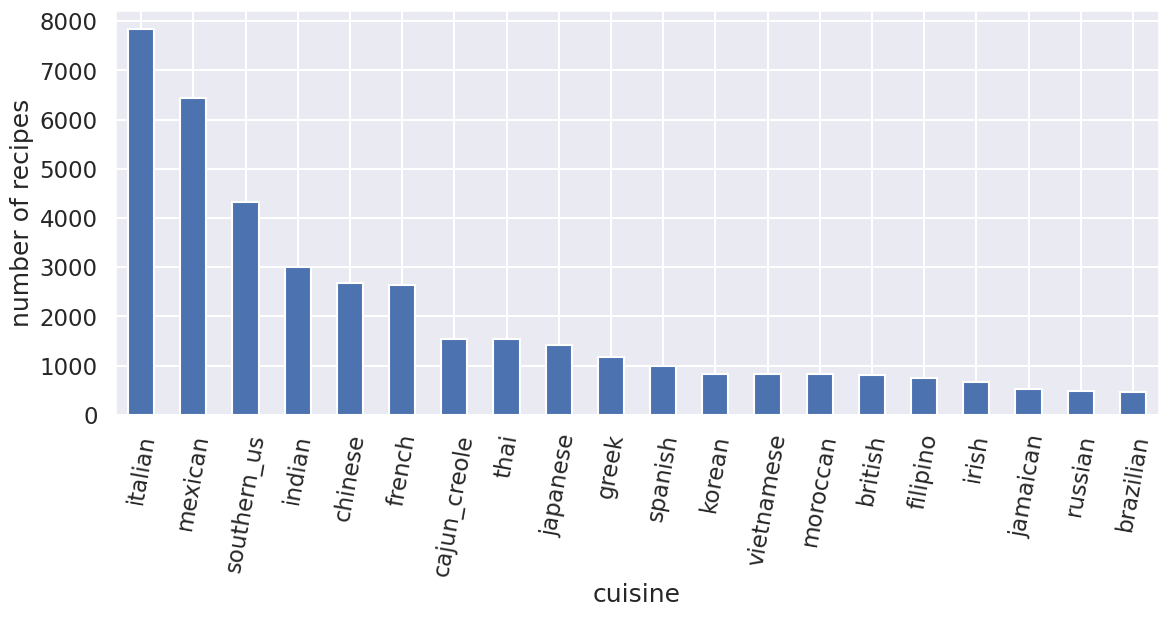

In [9]:
# A glismpse of data
with sns.axes_style('darkgrid'), sns.plotting_context('talk'):
    pd.value_counts(train_data['cuisine']).plot.bar(figsize=(12, 5))
    plt.xticks(rotation=80)
    plt.ylabel('number of recipes')

#### data clean

In [7]:
# I am trying to use the methods from what I learned in Titanic discussion, so I concatenate the columns.
# Drop the Survived column to keep only features
features = train_data.drop(columns=['cuisine'])
# Convert all columns to string
features = features.astype(str)
# Concatenate all rows
train_data['text'] = features.apply(lambda x: ' '.join(x), axis=1)

In [10]:

train_data = train_data.astype(str)
train_data['text'] = train_data.apply(lambda x: ' '.join(x), axis=1)
def clean_text(text):
    text = text.lower() # convert to lowercase
    text = re.sub(r'[^a-z0-9\s]', '', text) # remove non-alphanumeric characters
    return text
train_data['text'] = train_data['text'].apply(clean_text)

In [11]:
def clean_html(text):
    CLEANR = re.compile("<.*?>:")
    text = re.sub(CLEANR, ' ', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A) #lower case
    return text
    
def rem_lines(text):
    return text.strip().replace('\n', ' ')
    
def convert_emoticons(text):
    for emot in EMOTICONS_EMO:
        text = text.replace(emot, EMOTICONS_EMO[emot]+" ".replace("",""))
    return text
    
def convert_emojis(text):
    for emot in UNICODE_EMOJI:
        text = text.replace(emot,UNICODE_EMOJI[emot]+" ".replace("",""))
    return text
    
def remove_stopwords(text):
    return [word for word in word_tokenize(text) if not word in stopwords]

def strip_punctuation(text):
    return ''.join(c for c in text if c not in punctuation)+' '

def to_number(text):
    return(re.sub(r"(\d+)", lambda x: num2words(int(x.group(0))), text))

def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return ' '.join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

In [12]:
def number_to_words(text):
    word_map = {
        '0': 'zero',
        '1': 'one',
        '2': 'two',
        '3': 'three',
        '4': 'four',
        '5': 'five',
        '6': 'six',
        '7': 'seven',
        '8': 'eight',
        '9': 'nine'
    }
    return ' '.join([word_map.get(i, i) for i in text.split()])

train_data['text'] = train_data['text'].apply(number_to_words)

In [19]:
print(train_data[['text']].head())
print(train_data.info())

                                                text
0  10259 greek romaine lettuce black olives grape...
1  25693 southernus plain flour ground pepper sal...
2  20130 filipino eggs pepper salt mayonaise cook...
3  22213 indian water vegetable oil wheat salt 22...
4  13162 indian black pepper shallots cornflour c...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           39774 non-null  object
 1   cuisine      39774 non-null  object
 2   ingredients  39774 non-null  object
 3   text         39774 non-null  object
dtypes: object(4)
memory usage: 1.2+ MB
None


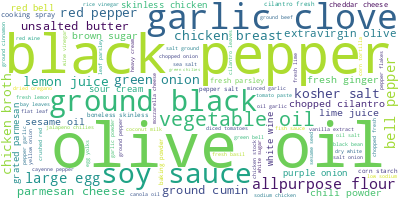

In [18]:
# I just remember something that I learned from AI 1, making a word cloud. 

# Join the different processed titles together.
long_string = ','.join(train_data['text'])
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=120000, contour_width=10, 
                      contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

#### build models

In [49]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer as TFIDF
#split into training/test data
from sklearn.model_selection import train_test_split as tts
trainX, testX, trainy, testy= tts(train_data['text'], train_data['cuisine'],test_size=0.2,random_state=42)
tv = TFIDF(use_idf=True, min_df=0.0, max_df=1.0)
tv_train = tv.fit_transform(trainX)
tv_test = tv.transform(testX)

# Train a classifier (you can use any classifier you prefer)
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(tv_train, trainy)

# Predict on the test set
y_pred = clf.predict(tv_test)

# Calculate accuracy
accuracy = accuracy_score(testy, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.98


In [57]:
# export prediction data after using test data for prediction
test_data['text'] = test_data['ingredients'].apply(lambda x: ' '.join(x))

# Transform the test data using the TF-IDF vectorizer trained on your training data
tv_test = tv.transform(test_data['text'])

# Make predictions using your trained classifier (clf)
y_pred = clf.predict(tv_test)

# Create a DataFrame with test IDs and predicted cuisine labels
test_id = test_data['id']
predictions = pd.DataFrame({'id': test_id, 'cuisine': y_pred})

# Save the predictions to a CSV file
predictions.to_csv('new_predictions.csv', index=False)  # Save to a new CSV file for the new test data


In [32]:
# LDA model
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)
# Create a gensim dictionary and corpus
dictionary = corpora.Dictionary([doc.split() for doc in X_train])
corpus = [dictionary.doc2bow(doc.split()) for doc in X_train]

# Train an LDA model
lda_model = models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

# Print the topics and their top words
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.054*"sauce" + 0.039*"oil" + 0.029*"soy" + 0.027*"sugar" + 0.027*"garlic"')
(1, '0.055*"sugar" + 0.051*"flour" + 0.040*"butter" + 0.034*"salt" + 0.032*"allpurpose"')
(2, '0.040*"ground" + 0.029*"salt" + 0.029*"pepper" + 0.024*"garlic" + 0.023*"powder"')
(3, '0.065*"fresh" + 0.045*"lemon" + 0.043*"oil" + 0.042*"olive" + 0.042*"juice"')
(4, '0.053*"pepper" + 0.035*"cheese" + 0.029*"salt" + 0.029*"garlic" + 0.026*"oil"')


In [58]:
# export prediction data after using test data for prediction
# Create a gensim dictionary and corpus for the test data
test_corpus = [dictionary.doc2bow(doc.split()) for doc in test_data['text']]

# Infer topic distributions for the test data using the trained LDA model
test_lda = [lda_model[doc] for doc in test_corpus]

# Assign cuisine labels based on the dominant topic for each test document
def get_dominant_topic(lda_topic):
    if not lda_topic:
        return None
    return max(lda_topic, key=lambda x: x[1])[0]

test_data['dominant_topic'] = [get_dominant_topic(lda_topic) for lda_topic in test_lda]

# Map dominant topics to cuisine labels (you may need to customize this)
topic_to_cuisine = {
    0: 'italian',
    1: 'mexican',
    2: 'indian',
    3: 'chinese',
    4: 'french'
}

test_data['cuisine'] = test_data['dominant_topic'].map(topic_to_cuisine)

# Create a DataFrame with test IDs and predicted cuisine labels
test_id = test_data['id']
predictions = pd.DataFrame({'id': test_id, 'cuisine': test_data['cuisine']})

# Save the predictions to a CSV file
predictions.to_csv('lda_predictions.csv', index=False)


#### Kaggle score

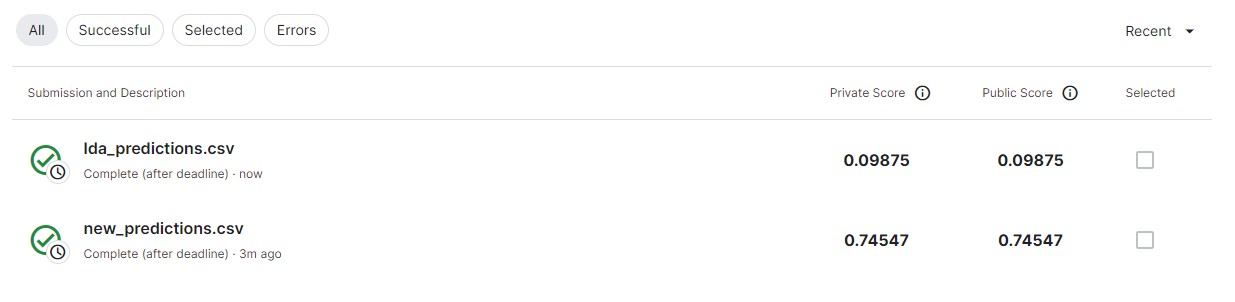

In [13]:
# insert PNG image
image_path = 'data/cook.png'
# Display the image
Image(filename=image_path)

# From the result, it looks like my LDA model did not perform well. My TF-IDF performed fair, although the name of that file is called new_prediction.